# Convnet Model and Training

This aim of notebook is to define the siamese model that will be used for the Humpback Whale challenge. It will also run the model to trainin it agains our previously generated training and validation dataset and also create the results agains a test dataset.

## 0. Module Imports 

In [36]:
import numpy as np
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

## 1. Load Training, Validation and Test datasets

In [2]:
pickle_file = '../data/Siamese_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X1_dataset = save['train_X1_dataset']
    train_X2_dataset = save['train_X2_dataset']
    train_labels = save['train_labels']
    valid_X1_dataset = save['valid_X1_dataset']
    valid_X2_dataset = save['valid_X2_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
    print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100) (31218, 44, 100) (31218,)
Validation set (5510, 44, 100) (5510, 44, 100) (5510,)


##  2. Declaration of Global Constants
Now we declare all the global constants in hee in orde to have them centralized.
This way we can easyly tune our model.

In [18]:
## Image parameters
NUM_CHANNELS = 1
IMAGE_HEIGHT = 44
IMAGE_WIDHT = 100

#Convnet parameters
BETA = 0.005
PATCH_1 = 5
PATCH_2 = 5
DEPTH_1 = 8
DEPTH_2 = 15
NUM_HIDEN = 1024
NUM_LABELS = 1


#Training parameters
BATCH_SIZE = 128
NUM_STEPS = 1001

## 3. Reformat datasets into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.



In [6]:
num_labels = 1

def reformat(dataset1, dataset2, labels):
  dataset1 = dataset1.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  dataset2 = dataset2.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset1, dataset2, labels
train_X1_dataset, train_X2_dataset, train_labels = reformat(train_X1_dataset, train_X2_dataset, train_labels)
valid_X1_dataset, valid_X2_dataset, valid_labels = reformat(valid_X1_dataset, valid_X2_dataset, valid_labels)
print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100, 1) (31218, 44, 100, 1) (31218, 1)
Validation set (5510, 44, 100, 1) (5510, 44, 100, 1) (5510, 1)


## 4. Definition of auxiliar functions

### 4.1. Accuracy computation

In [7]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## 5. Network declaration
We will use tensorflow

In [40]:

siamese_model = tf.Graph()

with siamese_model.as_default():

  # Input data.
    tf_train_X1_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_X2_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_X1_dataset = tf.constant(valid_X1_dataset)
    tf_valid_X2_dataset = tf.constant(valid_X2_dataset)
    #tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = {
      'layer1': tf.Variable(tf.truncated_normal(\
              [PATCH_1, PATCH_1, NUM_CHANNELS, DEPTH_1], stddev=0.1)),
      'layer2': tf.Variable(tf.truncated_normal(\
              [PATCH_2, PATCH_2, DEPTH_1, DEPTH_2], stddev=0.1)),
      'layer3': tf.Variable(tf.truncated_normal(\
              [IMAGE_HEIGHT // 4 * IMAGE_WIDHT // 4 * DEPTH_2, NUM_HIDEN], stddev=0.1)),
      'layer4': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN, 10], stddev=0.1))
      }
    biases = {
        'layer1' : tf.Variable(tf.zeros([DEPTH_1])),
        'layer2' : tf.Variable(tf.constant(1.0, shape=[DEPTH_2])),
        'layer3' : tf.Variable(tf.constant(1.0, shape=[NUM_HIDEN])),
        'layer4' : tf.Variable(tf.constant(1.0, shape=[1]))
        }
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights['layer1'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer1'])
        conv = tf.nn.conv2d(hidden, weights['layer2'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer2'])
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
        return tf.matmul(hidden, weights['layer4']) + biases['layer4']
    
    
  # Training computation.
    with tf.variable_scope("siamese") as scope:
        logits1 = model(tf_train_X1_dataset)
        print(logits1.shape)
        scope.reuse_variables()
        logits2 = model(tf_train_X2_dataset)
        print(logits2.shape)
        
    with tf.variable_scope("siamese_val") as scope:
        val_logits1 = model(tf_train_X1_dataset)
        print(logits1.shape)
        scope.reuse_variables()
        val_logits2 = model(tf_train_X2_dataset)
        print(logits2.shape)
        
    def loss(y):
        margin = 5.0
        labels_t = y
        labels_f = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(logits1, logits2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(margin, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
        
    loss = loss(tf_train_labels)
    
  # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.reduce_sum(tf.pow(tf.subtract(logits1, logits2), 2),1)
    valid_prediction = tf.reduce_sum(tf.pow(tf.subtract(val_logits1, val_logits2), 2),1)
    #test_prediction = tf.nn.softmax(model(tf_test_dataset))


(128, 10)
(128, 10)
(128, 10)
(128, 10)


## 6. Model training

Initialized
Minibatch loss at step 0: 7.126099
Minibatch loss at step 50: 6.438933
Minibatch loss at step 100: 6.738636
Minibatch loss at step 150: 6.537175
Minibatch loss at step 200: 6.644315
Minibatch loss at step 250: 6.649497
Minibatch loss at step 300: 6.646153
Minibatch loss at step 350: 6.545793
Minibatch loss at step 400: 6.429983
Minibatch loss at step 450: 6.410410
Minibatch loss at step 500: 6.616727
Minibatch loss at step 550: 6.472067
Minibatch loss at step 600: 6.515833
Minibatch loss at step 650: 6.305239
Minibatch loss at step 700: 6.479825
Minibatch loss at step 750: 6.308242
Minibatch loss at step 800: 6.319757
Minibatch loss at step 850: 6.171739
Minibatch loss at step 900: 6.504192
Minibatch loss at step 950: 6.317156
Minibatch loss at step 1000: 6.413850


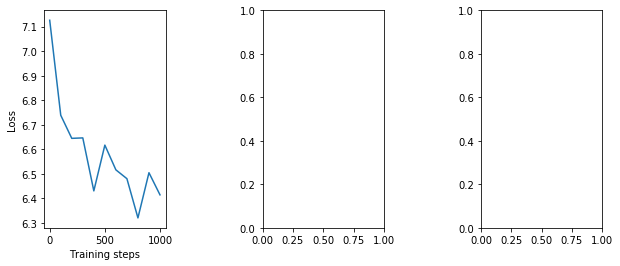

In [44]:
#Plots
P_FREQ = 100
losses = []
accuracies = []
rates = []

with tf.Session(graph=siamese_model) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data_X1 = train_X1_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_data_X2 = train_X2_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
    feed_dict = {tf_train_X1_dataset : batch_data_X1, tf_train_X2_dataset : batch_data_X2, \
                 tf_train_labels : batch_labels}
    _, _loss, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if np.isnan(_loss):
        print('Model diverged with loss = NaN')
        quit()
        
    #Plot variables
    if (step % P_FREQ == 0):
       losses.append(_loss)
       #accuracies.append(accuracy(valid_prediction.eval(), valid_labels))
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, _loss))
  
#print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, NUM_STEPS, P_FREQ), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
plt.show()
